## **Setup**

In [1]:
# Import the necesary packages
import os
import gc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
config = {
    # Basic information
    "AUTHOR": "Kiernan",
    
    # Training params
    "LR_STYLE": "REDUCE", #['REDUCE', 'SCHEDULE']
    "LR": 0.001,
    "BATCH_SIZE": 50,
    "EPOCHS": 40,
    
    # Loss parameters
    "LOSS": "SEMI_HARD", #['HARD', 'SEMI_HARD']
    "MARGIN": 0.5,
    "SOFT_MARGIN": False,
    "DIST_METRIC": "L2", #['L2','squared-L2','angular']
    
    # Model params
    "FIRST_FILTERS": 16,
    "N_FILTERS": 16,
    "CONV_LAYERS": 5,
    "FIRST_KERNEL_SIZE": (5,5),
    "KERNEL_SIZE": (3,3),
    "EMBEDDING_SIZE": 16,
    "DROPOUT": 0.2
}

## **Initialize WANDB**

In [3]:
import wandb
from wandb.keras import WandbCallback
from secrets import WANDB
wandb.login(key=WANDB)
run = wandb.init(project="deep-clustering-evaluation", entity="kmcguigan", group="triplet-model", config=config, job_type="train")

wandb: Currently logged in as: kmcguigan. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kiernan/.netrc


## **Loading Data**

### **Load the presplit data**

In [4]:
with open('data/train.npy', mode='rb') as infile:
    X_train = np.load(infile, allow_pickle=True)
    y_train = np.load(infile, allow_pickle=True)

with open('data/val.npy', mode='rb') as infile:
    X_val = np.load(infile, allow_pickle=True)
    y_val = np.load(infile, allow_pickle=True)

with open('data/test.npy', mode='rb') as infile:
    X_test = np.load(infile, allow_pickle=True)
    y_test = np.load(infile, allow_pickle=True)
    
IMAGE_SIZE = X_train.shape[-2]
print(f"Train data shape: {X_train.shape} Val data shape: {X_val.shape} Test data shape: {X_test.shape}")

Train data shape: (50000, 28, 28, 1) Val data shape: (10000, 28, 28, 1) Test data shape: (10000, 28, 28, 1)


In [5]:
labels = pd.read_csv('data/label_names.csv')
labels

,label,name
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


### **Create a data generator**

In [6]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.labels_names = labels['label'].values
        
        # image meta
        self.dims = (IMAGE_SIZE, IMAGE_SIZE)
        self.channels = 1
        
        # save the meta on what we will be choosing
        self.batch_size = config["BATCH_SIZE"]
        self.samples_per_class = self.batch_size // len(self.labels_names)
        assert(self.batch_size % self.samples_per_class == 0)
        
        # create the image loader
        self.indexer = {}
        # min_samples = None
        for cls in self.labels_names:
            self.indexer[cls] = np.where(y==cls)[0]
            
        # save the size of a single epoch of data
        self.batches_per_epoch = (self.X.shape[0] // self.batch_size) + 1
        
        super(CustomDataset, self).__init__()
    
    def __len__(self):
        return self.batches_per_epoch

    def on_epoch_end(self):
        gc.collect()
        return

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, *self.dims, self.channels))
        y = np.empty((self.batch_size), dtype=int)
        batch_idx = 0
        for cls in self.indexer.keys():
            samples = np.random.choice(self.indexer[cls], size=self.samples_per_class, replace=False)
            X[batch_idx:batch_idx+self.samples_per_class, :, :, :] = self.X[samples, :, :, :]
            y[batch_idx:batch_idx+self.samples_per_class] = self.y[samples]
            batch_idx = batch_idx+self.samples_per_class
        return X,y

In [7]:
train_ds = CustomDataset(X_train, y_train)
val_ds = CustomDataset(X_val, y_val)
test_ds = CustomDataset(X_test, y_test)

## **Define LR Callback**

In [8]:
def get_lr_callback(plot=False, batch_size=config['BATCH_SIZE'], epochs=config['EPOCHS']):
    lr_start   = config['LR']
    lr_max     = config['LR'] * 5 * batch_size  
    lr_min     = config['LR']
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    if(plot):
        epochs = list(range(epochs))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        ax = plt.gca()
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

if(config["LR_STYLE"] == "SCHEDULE"):
    lr_callback = get_lr_callback(plot=True)
elif(config["LR_STYLE"] == "REDUCE"):
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2)
else:
    raise Exception(f"config LR_STYLE {config['LR_STYLE']} is not understood")

## **Create Model**

### **Create the Model Body**

In [9]:
def create_body(image_shape):
    inputs = tf.keras.layers.Input(shape=image_shape)
    
    def resid_block(layer_inputs, n_filters, kernel_size, identity_block=False, **kwargs):
        x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same", activity_regularizer=tf.keras.regularizers.L1L2(l1=0.000001,l2=0.000001), **kwargs)(layer_inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        if(identity_block):
            layer_inputs = tf.keras.layers.Conv2D(n_filters, 1, padding="same", activity_regularizer=tf.keras.regularizers.L1L2(l1=0.000001,l2=0.000001), **kwargs)(layer_inputs)
        return x + layer_inputs
    
#     def conv_block(layer_inputs, n_filters, kernel_size, **kwargs):
#         x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same", **kwargs)(layer_inputs)
#         x = tf.keras.layers.BatchNormalization()(x)
#         x = tf.keras.layers.ReLU()(x)
#         return x
    
    x = resid_block(inputs, config["FIRST_FILTERS"], config["FIRST_KERNEL_SIZE"], identity_block=True, strides=2)
    x = resid_block(x, config["N_FILTERS"], config["KERNEL_SIZE"], identity_block=True if config["FIRST_FILTERS"]!=config["N_FILTERS"] else False)
    for _ in range(config["CONV_LAYERS"] - 1):
        x = resid_block(x, config["N_FILTERS"], config["KERNEL_SIZE"])
    
    x = tf.keras.layers.Conv2D(config["EMBEDDING_SIZE"], (1,1), padding="same")(x)
    outputs = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="body")

body = create_body(X_train.shape[1:])
body.summary()

Metal device set to: Apple M1 Pro


2022-11-16 20:16:28.747756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 20:16:28.747911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "body"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 16)   416         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 14, 14, 16)   0           ['batch_normalization[0][0]'] 

### **Create the full model**

In [10]:
model = tf.keras.models.Sequential([
    body,
],
    name="combinedModel"
)
if(config["LOSS"] == "HARD"):
    loss = tfa.losses.TripletHardLoss(margin=config["MARGIN"], distance_metric=config["DIST_METRIC"], soft=config["SOFT_MARGIN"])
elif(config["LOSS"] == "SEMI_HARD"):
    loss = tfa.losses.TripletSemiHardLoss(margin=config["MARGIN"], distance_metric=config["DIST_METRIC"], soft=config["SOFT_MARGIN"])
else:
    raise Exception(f"config LOSS of {config['LOSS']} is not understood")

optimizer = tf.keras.optimizers.Adam(learning_rate=config['LR'])

model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "combinedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 body (Functional)           (None, 16)                12704     
                                                                 
Total params: 12,704
Trainable params: 12,512
Non-trainable params: 192
_________________________________________________________________


## **Train the Model**

In [11]:
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hist = model.fit(train_ds,
                 validation_data=val_ds,
                 epochs=config["EPOCHS"],
                 callbacks=[stopper, lr_callback, WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/40


2022-11-16 20:16:39.137134: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-16 20:16:40.387260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1001/1001 [==============================] - ETA: 0s - loss: 0.1801

2022-11-16 20:17:07.676474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1001/1001 [==============================] - 32s 30ms/step - loss: 0.1801 - val_loss: 0.1134 - lr: 0.0010 - _timestamp: 1668647830.0000 - _runtime: 45.0000
Epoch 2/40
1001/1001 [==============================] - 30s 30ms/step - loss: 0.0706 - val_loss: 0.0655 - lr: 0.0010 - _timestamp: 1668647860.0000 - _runtime: 75.0000
Epoch 3/40
1001/1001 [==============================] - 29s 29ms/step - loss: 0.0531 - val_loss: 0.0665 - lr: 0.0010 - _timestamp: 1668647889.0000 - _runtime: 104.0000
Epoch 4/40
1001/1001 [==============================] - 29s 29ms/step - loss: 0.0450 - val_loss: 0.0539 - lr: 0.0010 - _timestamp: 1668647918.0000 - _runtime: 133.0000
Epoch 5/40
1001/1001 [==============================] - 29s 29ms/step - loss: 0.0406 - val_loss: 0.0438 - lr: 0.0010 - _timestamp: 1668647947.0000 - _runtime: 162.0000
Epoch 6/40
1001/1001 [==============================] - 29s 29ms/step - loss: 0.0380 - val_loss: 0.0436 - lr: 0.0010 - _timestamp: 1668647976.0000 - _runtime: 191.0000
Epoch

## **Vizualize Training Results**

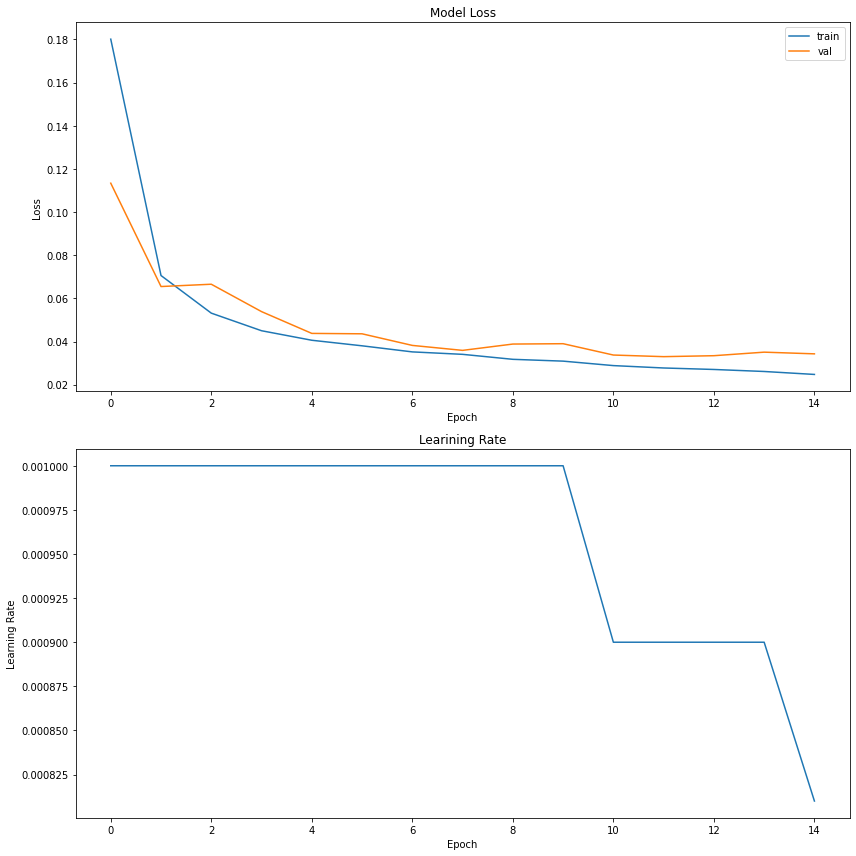

In [12]:
fig = plt.figure(figsize=(12,12), tight_layout=True)

plt.subplot(211)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(212)
plt.plot(hist.history['lr'])
plt.title('Learining Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')

run.log({'train_graph': wandb.Image(fig, caption="Training Graph")})
plt.show()

## **Analyze Results on the Test Set**

In [13]:
ev = model.evaluate(test_ds, return_dict=True)
log_dict = {f'test/{met}': val for met, val in ev.items()}
run.log(log_dict)

201/201 [==============================] - 3s 13ms/step - loss: 0.0318


In [14]:
def kmeans_cluster_accuracy(embeddings, y):
    kmeans = KMeans(n_clusters=10, random_state=123)
    labels = kmeans.fit_predict(embeddings)
    
    label_mappings = {}
    for label in np.unique(labels):
        values, counts = np.unique(y[np.where(labels==label)], return_counts=True)
        label_mappings[label] = values[np.argmax(counts)]
    
    map_labels = np.vectorize(lambda x: label_mappings[x])
    mapped_labels = map_labels(labels)
    return accuracy_score(y.reshape((-1,1)), mapped_labels.reshape((-1,1))), mapped_labels

embeddings = body.predict(X_test)
accuracy, preds = kmeans_cluster_accuracy(embeddings, y_test)
run.log({'test/clustering_accuracy':accuracy})
print(f"Cluster Accurancy {accuracy}")

 38/313 [==>...........................] - ETA: 0s

2022-11-16 20:24:00.970675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
Cluster Accurancy 0.9889


In [15]:
preds = model.predict(X_test)
cf = confusion_matrix(y_test, np.argmax(preds, axis=-1), normalize='true')

 31/313 [=>............................] - ETA: 0s

2022-11-16 20:24:02.273640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


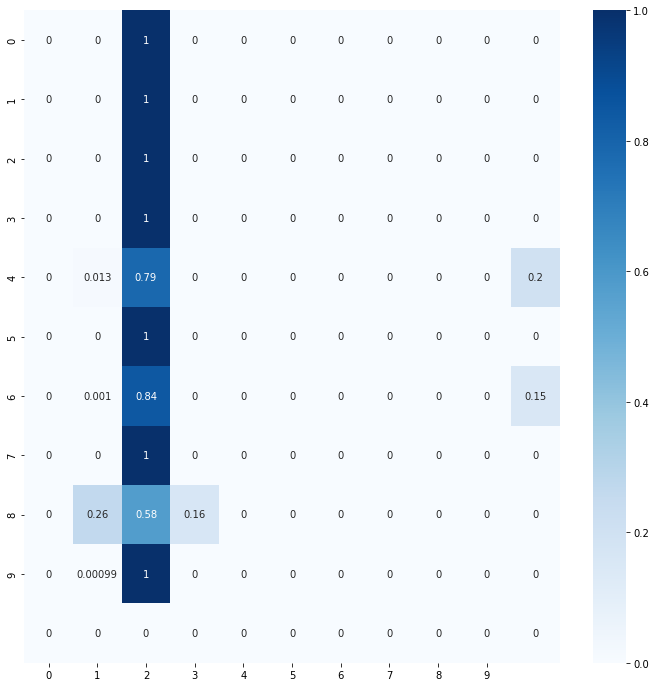

In [16]:
class_names = labels['name'].values
fig = plt.figure(figsize=(12,12))
sns.heatmap(cf, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues', robust=True)
run.log({'confusion_matrix': wandb.Image(fig, caption="Confusion Matrix")})
plt.show()

In [17]:
run.log({
    "testExamples": [wandb.Image(im, caption=f"Pred:{pred} Lable:{y}")
                        for im, pred, y in zip(X_test[:16,:,:,:], np.argmax(preds[:16], axis=-1), y_test[:16])]
})

## **Visualize the Clustering of the Embeddings**

References:

I found the code to make the very nice visualizations here

https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42#:~:text=t%2Ddistributed%20stochastic%20neighbour%20embedding,non%2Dlinear%20dimensionality%20reduction%20technique.


In [18]:
def tsne_embeddings(embeddings, y):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', verbose=1)
    embeddings = tsne.fit_transform(embeddings)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(22,12))
    num_categories = 10
    for lab in range(num_categories):
        indices = y==lab
        ax.scatter(
            embeddings[indices,0],
            embeddings[indices,1], 
            c=np.array(cmap(lab)).reshape(1,4), 
            label=labels['name'].values[lab], 
            alpha=0.5
        )
    ax.legend(fontsize='large', markerscale=2)
    run.log({'tsne_embeddings': wandb.Image(fig, caption="Test Embeddings")})
    plt.show()
    
# def tsne_embeddings_3d(embeddings, y):
#     tsne = TSNE(n_components=3, learning_rate='auto', init='random', verbose=1)
#     embeddings = tsne.fit_transform(embeddings)
#     cmap = cm.get_cmap('tab20')
#     fig = plt.figure(figsize=(22,12))
#     ax = fig.add_subplot(projection='3d')
#     num_categories = 10
#     for lab in range(num_categories):
#         indices = y == lab
#         ax.scatter(embeddings[indices, 0],
#                    embeddings[indices, 1],
#                    embeddings[indices, 2],
#                    c=np.array(cmap(lab)).reshape(1, 4),
#                    label=lab,
#                    alpha=0.5)
#     ax.legend(fontsize='large', markerscale=2)
#     plt.show()

embeddings = body.predict(X_test)

313/313 [==============================] - 1s 3ms/step


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 1.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.575469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.889259
[t-SNE] KL divergence after 1000 iterations: 1.465969


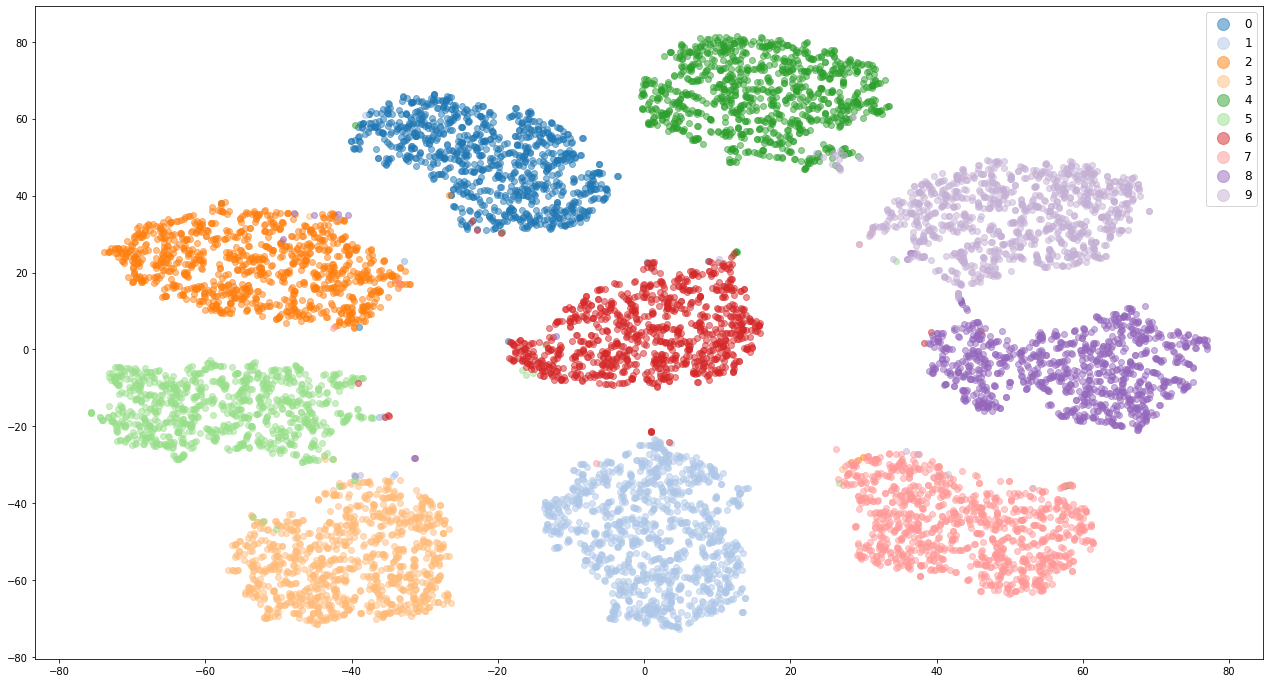

In [19]:
tsne_embeddings(embeddings, y_test)

## **Calculate the Positive and Negative Angular Distances**

In [20]:
def angular_distances(embeddings):
    embeddings = tf.math.l2_normalize(embeddings, axis=-1)
    cos = tf.matmul(embeddings, tf.transpose(embeddings))
    theta = tf.acos(cos)
    theta = tf.linalg.set_diag(theta, tf.zeros(tf.shape(embeddings)[0]))
    return theta
    
def euclidean_distances(embeddings):
    samples, dims = tf.shape(embeddings)
    euclidean_distances = []
    for sample_idx in range(samples):
        euclidean_distances.append(tf.linalg.norm(embeddings - embeddings[sample_idx,:], axis=-1))
    euclidean_distances = tf.stack(euclidean_distances)
    euclidean_distances = tf.linalg.set_diag(euclidean_distances, tf.zeros(tf.shape(euclidean_distances)[0]))
    return euclidean_distances

def apply_metric(embeddings, labels, metric):
    # reshape the labels and find where they match versus the transposed version
    labels = tf.reshape(labels, (-1,1))
    adj = tf.equal(labels, tf.transpose(labels))
    adj_not = tf.math.logical_not(adj)
    # remove self from the adj list
    diag = tf.zeros([tf.shape(labels)[0]])
    diag = tf.cast(diag, tf.bool)
    adj = tf.linalg.set_diag(adj, diag)
    # caluclate the distances between points
    distances = metric(embeddings)
    pos_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(distances, mask=adj))
    neg_dist_mean = tf.reduce_mean(tf.ragged.boolean_mask(distances, mask=adj_not))
    return pos_dist_mean, neg_dist_mean

In [21]:
pos_dist_mean, neg_dist_mean = apply_metric(embeddings, y_test, angular_distances)
run.log({'test/positive_angular_distances':pos_dist_mean,"test/negative_angular_distances":neg_dist_mean})
print(f"Positive Angular Distances: {pos_dist_mean}")
print(f"Negative Angular Distances: {neg_dist_mean}")

Positive Angular Distances: 0.15060167014598846
Negative Angular Distances: 0.5900760293006897


In [22]:
pos_dist_mean, neg_dist_mean = apply_metric(embeddings, y_test, euclidean_distances)
run.log({'test/positive_euclidean_distances':pos_dist_mean,"test/negative_euclidean_distances":neg_dist_mean})
print(f"Positive Euclidean Distances: {pos_dist_mean}")
print(f"Negative Euclidean Distances: {neg_dist_mean}")

Positive Euclidean Distances: 3.070949077606201
Negative Euclidean Distances: 11.736612319946289


## **Calculate the Spatial Area on Each Cluster**

After looking at the distances between positive and negative examples we want to look at the clusters themselves to understand the effectiveness of this clustering technique. This will be accomplished by looking at the overall area of different desity levels of the cluster, the area of positive samples within the clusters, and the area of negative samples within the cluster. To learn weather negative examples are evenly distributed throughout the cluster, or if they are meaningfully placed more towards the outside of the cluster we will look at the area from the center of the cluster until we encouter a certain quantile of false positives.

add a vector to each basis, expand the vectors until the area of these basis vecotors do not 

This could theoretically go inf on a specific plane. If the embeddings are placed on the unit circle this would limit it?

## **Finish the Run and Upload the Results**

In [23]:
run.finish()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
lr,██████████▄▄▄▄▁
test/clustering_accuracy,▁
test/loss,▁
test/negative_angular_distances,▁
test/negative_euclidean_distances,▁
test/positive_angular_distances,▁
test/positive_euclidean_distances,▁
val_loss,█▄▄▃▂▂▁▁▂▂▁▁▁▁▁
best_epoch,11
